# Learning Stable Control-oriented Deep Koopman Operators  


This tutorial demonstrates the use of [Deep Koopman Operators](https://www.nature.com/articles/s41467-018-07210-0) (DeepKO) with stability guarantees for system identificaiton of nonautonomous nonlinear dynamical systems in NeuroMANCER. 


## Koopman System Identification with Control Problem Setup

<img src="../figs/Koopman_model.png" width="500">  


System observables  $y_{k}$ and control inputs $u_k$ are encoded via encoder neural networks $f_y$ and $f_u$ to generate latent states $x_{k}$ (linear coordinates). This coordinate transformation now allos to apply linear Koopman operator $K$ to obtain latent states at the next time step $x_{k+1}$. After the rollout over given prediction horizon $N$ the generated latent trajectories $\{x_1, ..., x_N \}$ are proejcted back to the observable space via decoder neural network $f_y^{-1}$.
Now this Koopman encoder-decoder model can be trained as any other black-box nonlinear system identification problem with the loss $\mathcal{L}$ evaluated by comparing the  trajectory generated by the model with the training trajectory. 


### Koopman with Control References

[1] [H. Shi and M. Q. . -H. Meng, "Deep Koopman Operator With Control for Nonlinear Systems," in IEEE Robotics and Automation Letters, vol. 7, no. 3, pp. 7700-7707, July 2022, doi: 10.1109/LRA.2022.3184036.](https://ieeexplore.ieee.org/document/9799788)  
[2] [Eurika Kaiser and J Nathan Kutz and Steven L Brunton, Data-driven discovery of Koopman eigenfunctions for control, Mach. Learn.: Sci. Technol. 2021](https://iopscience.iop.org/article/10.1088/2632-2153/abf0f5)  
[3] [M. Korda and I. Mezić, "Optimal Construction of Koopman Eigenfunctions for Prediction and Control," in IEEE Transactions on Automatic Control, vol. 65, no. 12, pp. 5114-5129, Dec. 2020](https://ieeexplore.ieee.org/document/9022864)  
[4] [Yiqiang Han, Wenjian Hao, Umesh Vaidya, Deep Learning of Koopman Representation for Control, 2020
](https://arxiv.org/abs/2010.07546)  
[6] [Minghao Han, Jacob Euler-Rolle, Robert K. Katzschmann, DeSKO: Stability-Assured Robust Control with a Deep Stochastic Koopman Operator, ICLR 2022](https://openreview.net/forum?id=hniLRD_XCA)  
[6] https://github.com/HaojieSHI98/DeepKoopmanWithControl


### Generic Stable Layers References
[7]  [E. Skomski, S. Vasisht, C. Wight, A. Tuor, J. Drgoňa and D. Vrabie, "Constrained Block Nonlinear Neural Dynamical Models," 2021 American Control Conference (ACC), New Orleans, LA, USA, 2021, pp. 3993-4000](https://ieeexplore.ieee.org/document/9482930)   
[8] [J. Drgoňa, A. Tuor, S. Vasisht and D. Vrabie, "Dissipative Deep Neural Dynamical Systems," in IEEE Open Journal of Control Systems, 2022](https://ieeexplore.ieee.org/abstract/document/9809789)  
[9] [Jiong Zhang, Qi Lei, Inderjit S. Dhillon, Stabilizing Gradients for Deep Neural Networks via Efficient SVD Parameterization, InternationalConferenceonMachine Learning, 2018](https://arxiv.org/abs/1803.09327)



## NeuroMANCER and Dependencies

### Install (Colab only)
Skip this step when running locally.

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import pickle 
import scipy
import time as tim

from neuromancer.psl import plot
from neuromancer import psl
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from neuromancer.system import Node, System
from neuromancer.slim import slim
from neuromancer.trainer import Trainer
from neuromancer.problem import Problem
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer. modules import blocks
import joblib

from sklearn.preprocessing import StandardScaler, MinMaxScaler
torch.manual_seed(0)

## Generate trajectories from ODE system 

In this example we don't assume any prior knowledge on the system dynamics. We will only have access to limited measurements of the system states $x$ of an unknown [ordinary differential equations](https://en.wikipedia.org/wiki/Ordinary_differential_equation) (ODE).

Select the system_name from the available list of [nonautonomous ODE systems](https://github.com/pnnl/neuromancer/blob/master/src/neuromancer/psl/nonautonomous.py):
- TwoTank
- CSTR
- SwingEquation
- IverSimple

# Get and save data - (Already done)

## Create training data of sampled trajectories

We will obtain a dataset of sampled trajectories of the system dynamics in the form of input-state tuples: 
$$D = \big[(u^i_0, \hat{x}^i_0), ..., (u^i_N, \hat{x}^i_{N}) \big], \, \, i \in [1, ..., m]$$
where $N$ represents the prediction horizon, $m$ represents number of measured trajectories, and $i$ represents an index of the sampled trajectory.
Variables $x_k$ represent system states, and $u_k$ are exogenous inputs at time $k$.

In [3]:
with open('data/train_real.pkl', 'rb') as fp:
        train_sim = pickle.load(fp)

with open('data/test_real.pkl', 'rb') as fp:
        test_sim = pickle.load(fp)

In [4]:
def get_data(nx, nu, nsteps, bs, scaler, scalerU):
    """
    :param nsteps: (int) Number of timesteps for each batch of training data
    :param sys: (psl.system)
    :param ts: (float) step size
    :param bs: (int) batch size

    """

    with open('data/train_real.pkl', 'rb') as fp:
        train_sim = pickle.load(fp)
        
    with open('data/train_real.pkl', 'rb') as fp:
        dev_sim = pickle.load(fp)

    with open('data/test_real.pkl', 'rb') as fp:
        test_sim = pickle.load(fp)
    

    train_sim['Y'] = np.vstack((train_sim['Y'], test_sim['Y']))
    train_sim['U'] = np.vstack((train_sim['U'], test_sim['U']))
    
    nsim = train_sim['Y'].shape[0]
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps

    trainX = scaler.transform(train_sim['Y'][:length])
    trainX = trainX.reshape(nbatch, nsteps, nx)
    trainX = torch.tensor(trainX, dtype=torch.float32)
    trainU = scalerU.transform(train_sim['U'][:length])
    trainU = trainU.reshape(nbatch, nsteps, nu)
    trainU = torch.tensor(trainU, dtype=torch.float32)
    train_data = DictDataset({'Y': trainX, 'Y0': trainX[:, 0:1, :],
                              'U': trainU}, name='train')
    train_loader = DataLoader(train_data, batch_size=bs,
                              collate_fn=train_data.collate_fn, shuffle=True)
    
    nsim = dev_sim['Y'].shape[0]
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps
    
    devX = scaler.transform(dev_sim['Y'][:length])
    devX = devX.reshape(nbatch, nsteps, nx)
    devX = torch.tensor(devX, dtype=torch.float32)
    devU = scalerU.transform(dev_sim['U'][:length])
    devU = devU[:length].reshape(nbatch, nsteps, nu)
    devU = torch.tensor(devU, dtype=torch.float32)
    dev_data = DictDataset({'Y': devX, 'Y0': devX[:, 0:1, :],
                            'U': devU}, name='dev')
    dev_loader = DataLoader(dev_data, batch_size=bs,
                            collate_fn=dev_data.collate_fn, shuffle=True)

    nsim = test_sim['Y'].shape[0]
    nbatch = nsim//nsteps
    length = (nsim//nsteps) * nsteps
    
    testX = scaler.transform(test_sim['Y'][:length])
    testX = testX.reshape(1, nbatch*nsteps, nx)
    testX = torch.tensor(testX, dtype=torch.float32)
    testU = scalerU.transform(test_sim['U'][:length])
    testU = testU.reshape(1, nbatch*nsteps, nu)
    testU = torch.tensor(testU, dtype=torch.float32)
    test_data = {'Y': testX, 'Y0': testX[:, 0:1, :],
                 'U': testU}

    return train_loader, dev_loader, test_data

In [5]:
   # number of simulation steps in the dataset
nsteps = 80   # number of prediction horizon steps in the loss function
bs = 100      # minibatching batch size

scaler = StandardScaler()
scaler.fit(train_sim['Y'])  # Fit only on training data
joblib.dump(scaler, 'data/scaler.pkl')

scalerU = StandardScaler()
scalerU.fit(train_sim['U'])
joblib.dump(scalerU, 'data/scalerU.pkl')

nx = train_sim['Y'].shape[1]
ny = train_sim['Y'].shape[1]
nu = train_sim['U'].shape[1]

train_loader, dev_loader, test_data = get_data(nx, nu, nsteps, bs, scaler, scalerU)

In [6]:
train_sim['Y'].shape[0]

3603

In [7]:
scaler.inverse_transform([[0]])

array([[46.99871319]])

## Deep Koopman model in Neuromancer

Here we construct a discrete-time encoder-decoder Koopman model with control:   

<img src="../figs/Koopman_model.png" width="500">  


Encoder: $${x}_{k} = f_y(y_k) +f_u(u_k)$$ 
Koopman: $${x}_{k+1} = K(x_k)$$ 
Decoder: $$\hat{y}_{k+1} = f_y^{-1}(x_{k+1})$$  

In [8]:
# model parameters
nx_koopman = 10
n_hidden = 60
n_layers = 3
layers = [60, 60, 60]

**Encoder and Decoder networks** 

In [9]:
# instantiate output encoder neural net f_y
f_y = blocks.MLP(
    ny,
    nx_koopman,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=torch.nn.ReLU,
    hsizes=layers,
)
# initial condition encoder
encode_Y0 = Node(f_y, ['Y0'], ['x'], name='encoder_Y0')
# observed trajectory encoder
encode_Y = Node(f_y, ['Y'], ['x_latent'], name='encoder_Y')

In [10]:
# instantiate input encoder net f_u

f_u = torch.nn.Linear(nu, nx_koopman, bias=False)
# initial condition encoder
encode_U = Node(f_u, ['U'], ['u_latent'], name='encoder_U')

In [11]:
# instantiate state decoder neural net f_y_inv
f_y_inv = blocks.MLP(nx_koopman, ny, bias=True,
                linear_map=torch.nn.Linear,
                nonlin=torch.nn.ELU,
                hsizes=layers)
#f_y_inv = torch.nn.Linear(nx_koopman, ny, bias=False)
# predicted trajectory decoder
decode_y = Node(f_y_inv, ['x'], ['yhat'], name='decoder_y')

**Standard Koopman Operator** without stability guarantees is parametrized by linear layer of the latent size. 

**Stable Koopman Operator:**  For provably stable Koopman operator we can choose a range of linear algebra factorization that allow to constrain the eigenvalues of the resulting linear operator. 
In this example we use the following [Singular Value Decomposition (SVD)](https://en.wikipedia.org/wiki/Singular_value_decomposition) factorization of the operator given as:
$$K = U \Sigma V$$ 
$$\Sigma =  \text{diag}(\lambda_{\text{max}} - (\lambda_{\text{max}} - \lambda_{\text{min}}) \cdot \sigma(\Lambda)) $$
where $\sigma$ is logistic sigmoid activation function, $\cdot$ is a dot product, $\Lambda$ is a vector of eigenvalues of the linear operator, while $\lambda_{\text{max}}$ and $\lambda_{\text{min}}$ are constraints on maximum and minimum value of SVD factorized linear operator.

<img src="../figs/SVD_layer.png" width="300">  

In order for the SVD factorization to hold the left and right matrices $U$ and $V$, respectively, needs to be [orthogonal](https://en.wikipedia.org/wiki/Orthogonal_matrix).
This can be achieved either via [Householder reflectors](https://arxiv.org/abs/1803.09327), or via penalties in the loss function given as:  
$$\ell_{U} = || I - UU^T||_2 + || I - U^TU||_2  $$
$$\ell_{V} = || I - VV^T||_2 + || I - V^TV||_2  $$
$$\ell_{\text{stable}} = \ell_{U} + \ell_{V} $$

For more details on the SVD and other linear algebra factorizations of trainable linear layers see the references [[7]](https://ieeexplore.ieee.org/document/9482930) and [[8]](https://ieeexplore.ieee.org/abstract/document/9809789), with Pytorch implementations in the [slim submodule](https://github.com/pnnl/neuromancer/tree/master/src/neuromancer/slim) of the Neuromancer library. 

In [12]:
# instantiate Koopman operator matrix
stable = False     # if True then provably stable Koopman operator
if stable:
    # SVD factorized Koopman operator with bounded eigenvalues: sigma_min <= \lambda_i <= sigma_max
    K = slim.linear.SVDLinear(nx_koopman, nx_koopman,
                          sigma_min=0.01, sigma_max=1.0, bias=False)
    # SVD penalty variable
    K_reg_error = variable(K.reg_error())
    # SVD penalty loss term
    K_reg_loss = 1.*(K_reg_error == 0.0)
    K_reg_loss.name = 'SVD_loss'
else:
    # linear Koopman operator without guaranteed stability
    K = torch.nn.Linear(nx_koopman, nx_koopman, bias=False)

In [13]:
class Koopman_control(nn.Module):
    """
    Baseline class for Koopman control model
    Implements discrete-time dynamical system:
        x_k+1 = K x_k + u_k
    with variables:
        x_k - latent states
        u_k - latent control inputs
    """

    def __init__(self, K):
        super().__init__()
        self.K = K

    def forward(self, x, u):
        """
        :param x: (torch.Tensor, shape=[batchsize, nx])
        :param u: (torch.Tensor, shape=[batchsize, nx])
        :return: (torch.Tensor, shape=[batchsize, nx])
        """
        x = self.K(x) + u
        return x

In [14]:
# symbolic Koopman model with control inputs
Koopman = Node(Koopman_control(K), ['x', 'u_latent'], ['x'], name='K')

# latent Koopmann rollout
dynamics_model = System([Koopman], name='Koopman', nsteps=nsteps)

In [15]:
# dynamics_model.show()

In [16]:
# put all nodes of the Koopman model together in a list of nodes
nodes = [encode_Y0, encode_Y, encode_U, dynamics_model, decode_y]

## Define Koopman system identification loss function terms

Here we define loss function terms to fit the encoded-decoder Koopman parameters $\theta$ from given time-series data.
The loss function terms follow the implementation as given in the reference [[2]](https://www.nature.com/articles/s41467-018-07210-0). 

**Output trajectory prediction loss:**  
$$\ell_y = \sum_{k=1}^{N} Q_y||y^i_{k+1} - \hat{y}^i_{k+1}||_2^2$$ 
**One step output prediction loss:**  
$$\ell_{y_1} = Q_{y_1}||y^i_2 - \hat{y}^i_2||_2^2$$ 

where $\hat{y}^i_{k+1} = \phi^{-1}_{\theta_3}(K^k_{\theta_2}(\phi_{\theta_1}(y^i_1))) $, 
and $N$ is defining length of the rollout (prediction) horizon.  

**Latent trajectory prediction loss:**  
$$\ell_{\text{lin}} = \sum_{k=1}^{N}  Q_x||\phi_{\theta_1}(y_{k+1}^i) - K^k\phi_{\theta_1}(y_1^i)||_2^2$$ 


In [17]:
# variables
Y = variable("Y")  # observed
yhat = variable('yhat')  # predicted output
x_latent = variable('x_latent')  # encoded output trajectory in the latent space
u_latent = variable('u_latent')  # encoded input trajectory in the latent space
x = variable('x')  # Koopman latent space trajectory

xu_latent = x_latent + u_latent  # latent state trajectory

# output trajectory tracking loss
y_loss = 10. * (yhat[:, 1:-1, :] == Y[:, 1:, :]) ^ 2
y_loss.name = "y_loss"

# one-step tracking loss
onestep_loss = 1.*(yhat[:, 1, :] == Y[:, 1, :])^2
onestep_loss.name = "onestep_loss"

# reconstruction loss
reconstruction_loss = 20.*(yhat[:, 0, :] == Y[:, 0, :])^2
reconstruction_loss.name = "reconstruction_loss"

# latent trajectory tracking loss
x_loss = 1. * (x[:, 1:-1, :] == xu_latent[:, 1:, :]) ^ 2
x_loss.name = "x_loss"


## Construct System ID learning problem

Given the training dataset $\hat{X} = [\hat{x}^i_0, ..., \hat{x}^i_{N}]$ we want to solve the following problem:
 
$$
\begin{align}
&\underset{\theta}{\text{minimize}}     && \sum_{i=1}^m \Big( \ell_{y} + \ell_{y_1}  +\ell_{\text{lin}} + \ell_{\text{recon}} + \ell_{\text{stable}} \Big) \\
&\text{subject to}    && \hat{y}^i_{k+1} = \phi^{-1}_{\theta_3}(K^k_{\theta_2}(\phi_{\theta_1}(y_1^i))) \\
\end{align}
$$  

In [18]:
# aggregate list of objective terms and constraints
objectives = [y_loss, x_loss, onestep_loss, reconstruction_loss]

if stable:
    objectives.append(K_reg_loss)

# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints=[])

# construct constrained optimization problem
problem = Problem(nodes, loss)

In [19]:
# plot computational graph
#problem.show()
print(problem.input_keys)
print(problem.output_keys)

['Y', 'yhat', 'Y0', 'x_latent', 'U', 'u_latent', 'x']
['C_ineq_violations', 'objective_loss', 'loss', 'C_violations', 'x_latent', 'C_eq_violations', 'penalty_loss', 'C_values', 'C_ineq_values', 'u_latent', 'C_eq_values', 'yhat', 'x']


In [20]:
problem(next(iter(train_loader)))

{'train_Y': tensor([[[-0.0943],
          [-0.0432],
          [-0.1284],
          ...,
          [ 1.2188],
          [ 1.2359],
          [ 1.2529]],
 
         [[ 0.2809],
          [ 0.2979],
          [ 0.2979],
          ...,
          [ 0.2126],
          [ 0.2126],
          [ 0.2126]],
 
         [[-0.0261],
          [-0.0261],
          [-0.0091],
          ...,
          [-0.0602],
          [-0.1284],
          [-0.0943]],
 
         ...,
 
         [[-0.3842],
          [-0.3842],
          [-0.3842],
          ...,
          [-0.4013],
          [-0.4013],
          [-0.3842]],
 
         [[-0.9129],
          [-0.9300],
          [-0.9300],
          ...,
          [-1.4075],
          [-1.3904],
          [-1.4075]],
 
         [[ 0.0250],
          [ 0.0421],
          [ 0.0250],
          ...,
          [-0.0091],
          [ 0.0421],
          [ 0.0080]]]),
 'train_Y0': tensor([[[-0.0943]],
 
         [[ 0.2809]],
 
         [[-0.0261]],
 
         [[-0.1625]],
 
 

## Solve the problem

We fit the unknown NODE parameters $\theta$ using stochastic gradient descent.

In [21]:
optimizer = torch.optim.Adam(problem.parameters(), lr=0.001)

trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    test_data,
    optimizer,
    patience=200,
    warmup=100,
    epochs=2000,
    eval_metric="dev_loss",
    train_metric="train_loss",
    dev_metric="dev_loss",
    test_metric="dev_loss",
)


In [22]:
# %% train
start = tim.time()
best_model = trainer.train()
problem.load_state_dict(best_model)
end = tim.time()


epoch: 0  train_loss: 25.79354476928711
epoch: 1  train_loss: 24.819217681884766
epoch: 2  train_loss: 23.946285247802734
epoch: 3  train_loss: 23.11656951904297
epoch: 4  train_loss: 22.281452178955078
epoch: 5  train_loss: 21.412147521972656
epoch: 6  train_loss: 20.498092651367188
epoch: 7  train_loss: 19.522624969482422
epoch: 8  train_loss: 18.46381378173828
epoch: 9  train_loss: 17.31249237060547
epoch: 10  train_loss: 16.049177169799805
epoch: 11  train_loss: 14.662039756774902
epoch: 12  train_loss: 13.157482147216797
epoch: 13  train_loss: 11.554011344909668
epoch: 14  train_loss: 9.909350395202637
epoch: 15  train_loss: 8.322305679321289
epoch: 16  train_loss: 6.914516448974609
epoch: 17  train_loss: 5.820266246795654
epoch: 18  train_loss: 5.192303657531738
epoch: 19  train_loss: 5.101314067840576
epoch: 20  train_loss: 5.44047737121582
epoch: 21  train_loss: 5.87093448638916
epoch: 22  train_loss: 6.0549821853637695
epoch: 23  train_loss: 5.855438232421875
epoch: 24  train_

In [23]:
import datetime

# Generate a string with the current timestamp
timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

#torch.save(best_model, "./data/model_" + timestamp_str + ".pth")

In [24]:
torch.save(best_model, "./data/model_noC.pth")

In [25]:
# load problem
#problem.load_state_dict(torch.load('data/model_20241028_105952.pth'),strict=False)

In [26]:
# elapsed time
# print(f"Elapsed time train: {end-start:.2f} sec")


## System Identification results

In [27]:
problem.nodes

ModuleList(
  (0): encoder_Y0(Y0) -> x
  (1): encoder_Y(Y) -> x_latent
  (2): encoder_U(U) -> u_latent
  (3): System(
    (nodes): ModuleList(
      (0): K(x, u_latent) -> x
    )
  )
  (4): decoder_y(x) -> yhat
)

In [28]:
# update the rollout length based on the test data
problem.nodes[3].nsteps = 3600

In [29]:
# Test set results
start = tim.time()
test_outputs = problem.step(test_data)
end = tim.time()
print(f"Elapsed time test: {end-start:.2f} sec")

pred_traj = test_outputs['yhat'][:, 1:-1, :].detach().numpy().reshape(-1, nx).T
true_traj = test_data['Y'][:, 1:pred_traj.shape[1]+1, ].detach().numpy().reshape(-1, nx).T
input_traj = test_data['U'].detach().numpy().reshape(-1, nu).T
pred_x = test_outputs['x'][:, 1:-1, :].detach().numpy().reshape(-1, nx_koopman).T

Elapsed time test: 0.56 sec


In [30]:
test_data['Y'].shape

torch.Size([1, 3600, 1])

In [31]:
test_data['Y'][:, 1:pred_traj.shape[1]+1, ].shape

torch.Size([1, 3599, 1])

In [32]:
test_outputs['yhat'][:, 1:-1, :].shape

torch.Size([1, 3599, 1])

In [33]:
pred_x.shape

(10, 3599)

In [34]:
test_data['Y'][:, 1:pred_traj.shape[1]+1, ].shape

torch.Size([1, 3599, 1])

In [35]:
np.mean((pred_traj - true_traj) ** 2)
#2*60; 40 0.06774564
#3*60 80 0.05942205
# 16 32 64 40 0.06478106
# 16 32 64 64 0.06103883
# 16 32 64 128 0.07568752
# 32 64 128 128 0.061701212

# 0.00673042


0.007629021

In [36]:
from scipy.signal import cont2discrete

# Given parameters
gain = 0.5444607363962202    # Example gain
tau = 69  # Example time constant
T = 1    # Sampling time (choose based on your application)

# Continuous-time state-space matrices
A = np.array([[-1/tau]])
B = np.array([[gain/tau]])
C = np.array([[1]])
D = np.array([[0]])

# Discretize using cont2discrete
system = (A, B, C, D)
discrete_system = cont2discrete(system, T, method='zoh')

# Extract discrete-time matrices
A_d, B_d, C_d, D_d, _ = discrete_system

print("Discrete A matrix:", A_d)
print("Discrete B matrix:", B_d)
print("Discrete C matrix:", C_d)
print("Discrete D matrix:", D_d)


Discrete A matrix: [[0.98561176]]
Discrete B matrix: [[0.00783383]]
Discrete C matrix: [[1]]
Discrete D matrix: [[0]]


In [37]:
input_traj[:,30]

array([0.32746318], dtype=float32)

In [38]:
x0 = test_data['Y0'][0].detach().numpy()
input_traj = test_data['U'].detach().numpy()
y_strejc = np.zeros((nx, 3601))
y_strejc[:, 0] = x0
for i in range(3600):
    y_strejc[:,i+1] = A_d @ y_strejc[:,i] + B_d @ input_traj[:,i]

In [39]:
x_enc = problem.nodes[0]({"Y0": test_data['Y'][:, 1:pred_traj.shape[1]+1, ]})#({"Y0": torch.from_numpy(pred_traj.reshape(1,-1,1)).float()})
y_endec = problem.nodes[4](x_enc)
y_ed = y_endec['yhat'][0].detach().numpy()

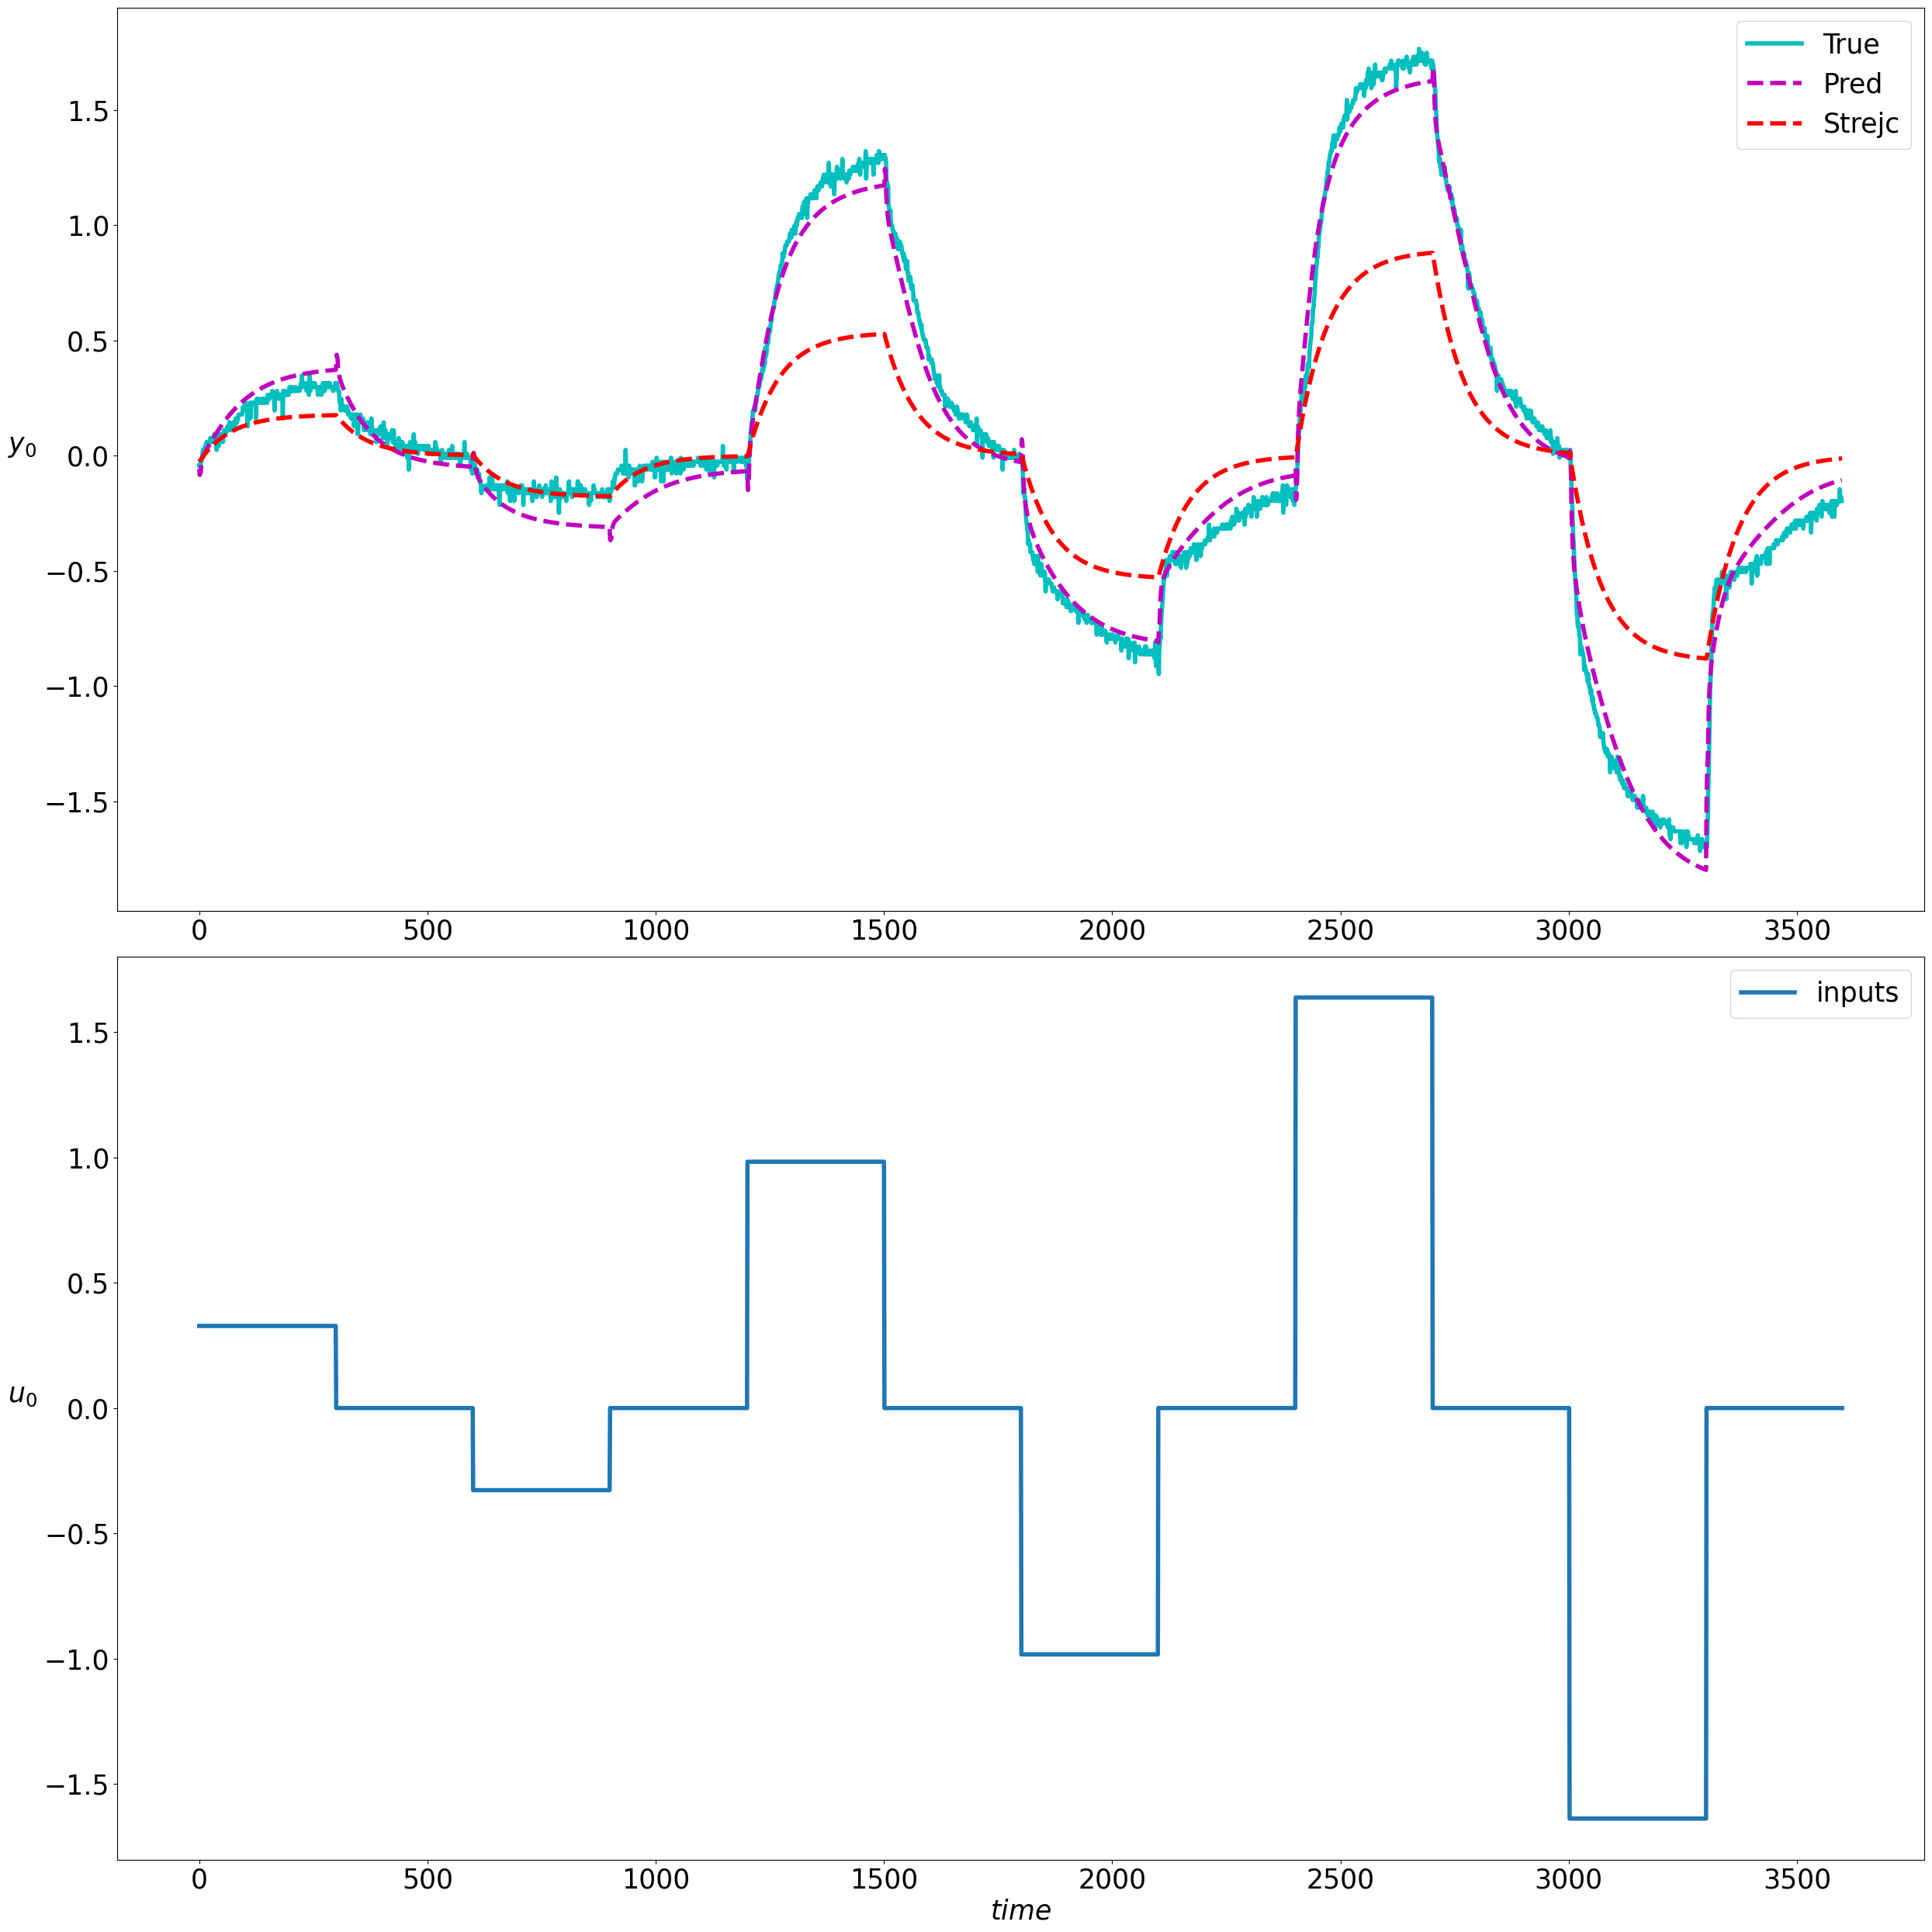

In [40]:
# plot trajectories
figsize = 25
fig, ax = plt.subplots(nx + nu, figsize=(figsize, figsize))
part = 3600

x_labels = [f'$y_{k}$' for k in range(len(true_traj))]
for row, (t1, t2, t3, t4, label) in enumerate(zip(true_traj, pred_traj, y_strejc, y_ed.T, x_labels)):
    axe = ax[row]
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.plot(t1[:part], 'c', linewidth=4.0, label='True')
    axe.plot(t2[:part], 'm--', linewidth=4.0, label='Pred')
    axe.plot(t3[:part], 'r--', linewidth=4.0, label='Strejc')
    #axe.plot(t4[:part], 'r-', linewidth=4.0, label='endec')
    axe.tick_params(labelbottom=False, labelsize=figsize)
axe.tick_params(labelbottom=True, labelsize=figsize)
axe.legend(fontsize=figsize)

u_labels = [f'$u_{k}$' for k in range(len(input_traj))]
for row, (u, label) in enumerate(zip(input_traj, u_labels)):
    axe = ax[row+nx]
    axe.plot(u[:part], linewidth=4.0, label='inputs')
    axe.legend(fontsize=figsize)
    axe.set_ylabel(label, rotation=0, labelpad=20, fontsize=figsize)
    axe.tick_params(labelbottom=True, labelsize=figsize)

ax[-1].set_xlabel('$time$', fontsize=figsize)
plt.tight_layout()

In [54]:
true_traj[0,0]

-0.043167356

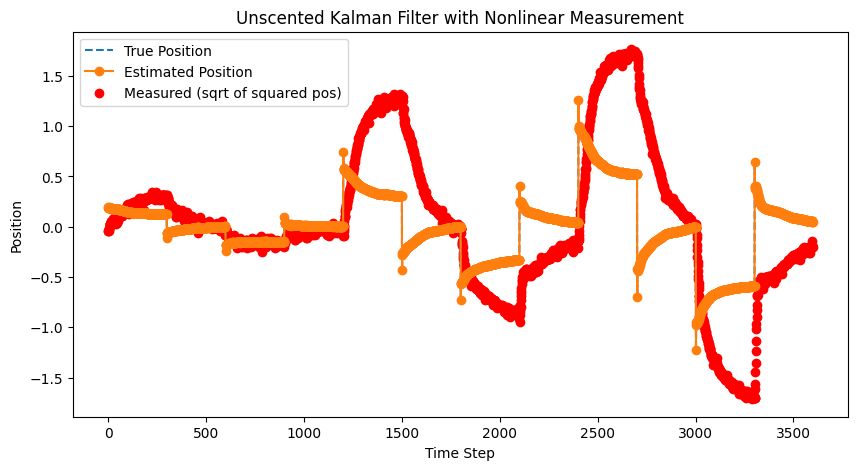

In [ ]:
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import MerweScaledSigmaPoints
A_noC = K.weight.detach().numpy()
B_noC = f_u.weight.detach().numpy()

def get_y_noC(x):
    y = problem.nodes[4]({"x": torch.from_numpy(x.T).float()})
    return y["yhat"][0].detach().numpy().reshape(1,-1).T

# Define the state transition function (Linear)
def f_cv(state, u):
    x = state.reshape(-1,1)
    x_new = A_noC@x + B_noC*u
    return x_new.flatten()

# Define the measurement function (Nonlinear)
def h_nonlinear(state):
    y = get_y_noC(state)
    return y.flatten()

# Define UKF parameters
dt = 1.0  # Time step
dim_x = 10  # Number of states [position, velocity]
dim_z = 1  # Number of measurements (nonlinear function of position)

# Create sigma points generator
sigmas = MerweScaledSigmaPoints(n=dim_x, alpha=0.1, beta=2.0, kappa=0)

# Initialize UKF
ukf = UKF(dim_x=dim_x, dim_z=dim_z, fx=f_cv, hx=h_nonlinear, dt=dt, points=sigmas)

# Set initial state and covariance
ukf.x = pred_x[:,0]  # Initial state: [position=2, velocity=1]
ukf.P = np.eye(dim_x) * 0.1  # Initial uncertainty

# Process and measurement noise
ukf.Q = np.eye(dim_x) * 0.01  # Process noise
ukf.R = np.eye(dim_z) * 0.1   # Measurement noise

# Simulate measurements
num_steps = 3599
true_states = []
measurements = []
estimated_states = []

for k in range(num_steps):
    u_k = input_traj[:,k]
    # Simulate true state
    true_state = f_cv(ukf.x, u_k)
    true_states.append(true_state)
    
    # Simulate nonlinear measurement with noise
    measurement = true_traj[0,k] #+ np.random.normal(0, 0.01)
    measurements.append(measurement)
    
    # UKF update step
    ukf.predict(dt=u_k)

    ukf.update(measurement)
    # Store estimates
    estimated_states.append(ukf.x.copy())

# Convert lists to arrays for plotting
true_states = np.array(true_states)
measurements = np.array(measurements)
estimated_states = np.array(estimated_states)


0.11206275061704218
0.0019191047120365307
[-1.3453513e-02  2.3560189e-03  2.1736175e-03  1.0492861e-02
 -9.5042884e-03  2.6948899e-03 -1.1864722e-02  3.7454069e-05
 -3.1172706e-02 -1.0809243e-02]
[ 0.19731626  0.23194818 -0.00366388 -0.09671969  0.05030767  0.14991918
  0.13585213 -0.17084098  0.00072141  0.09566683]


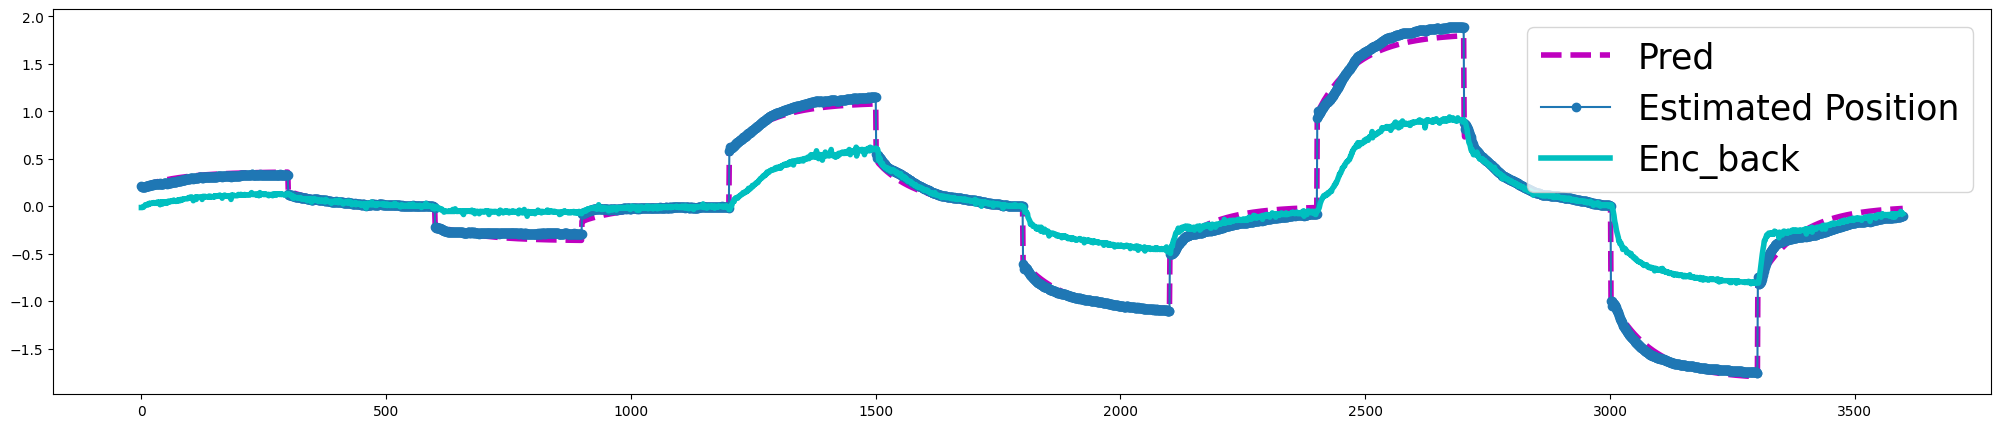

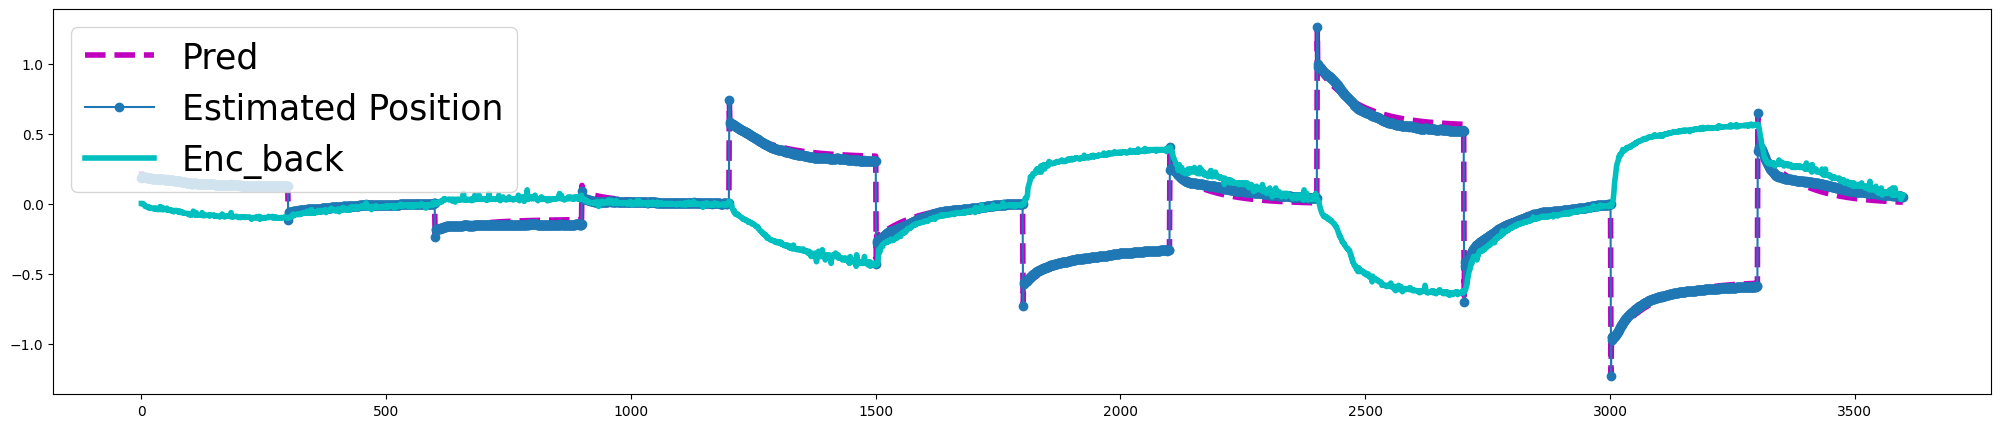

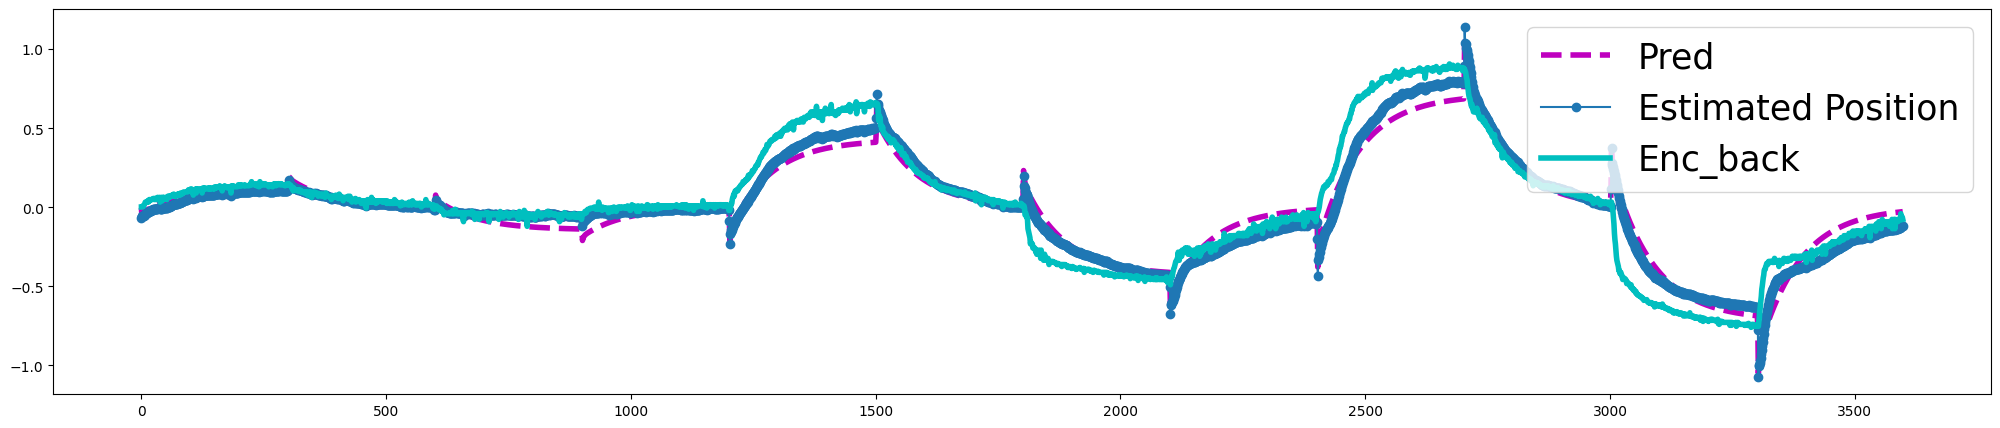

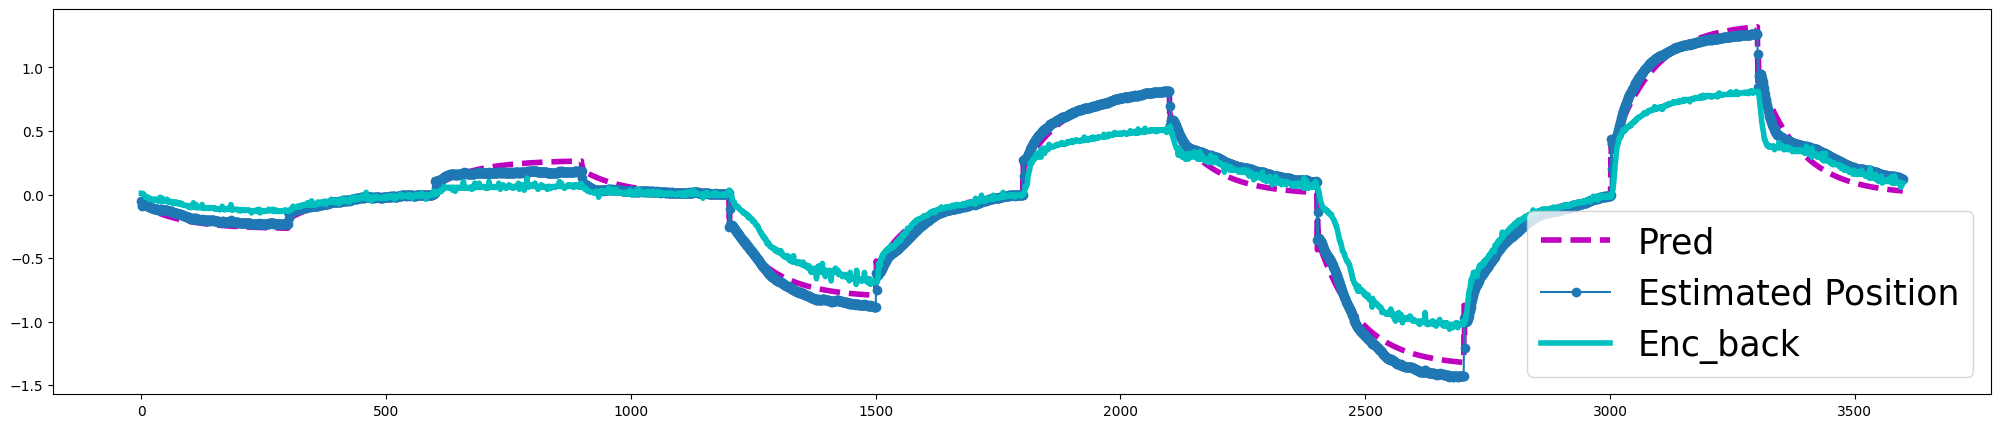

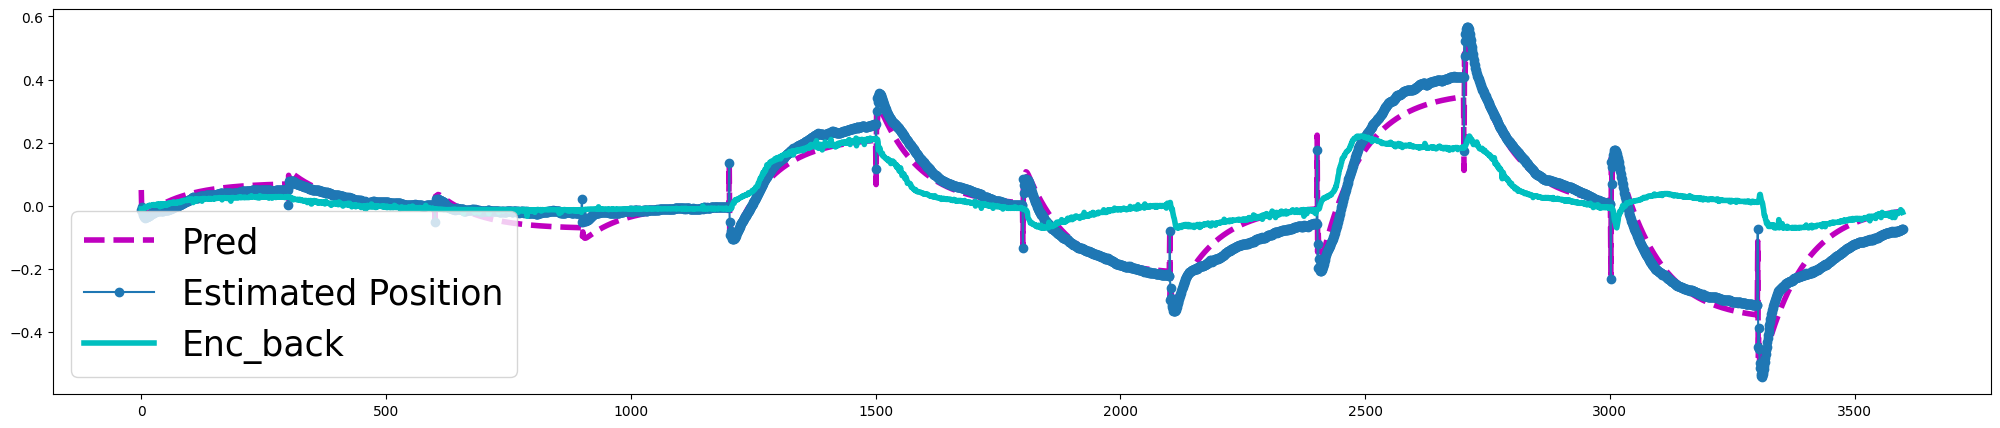

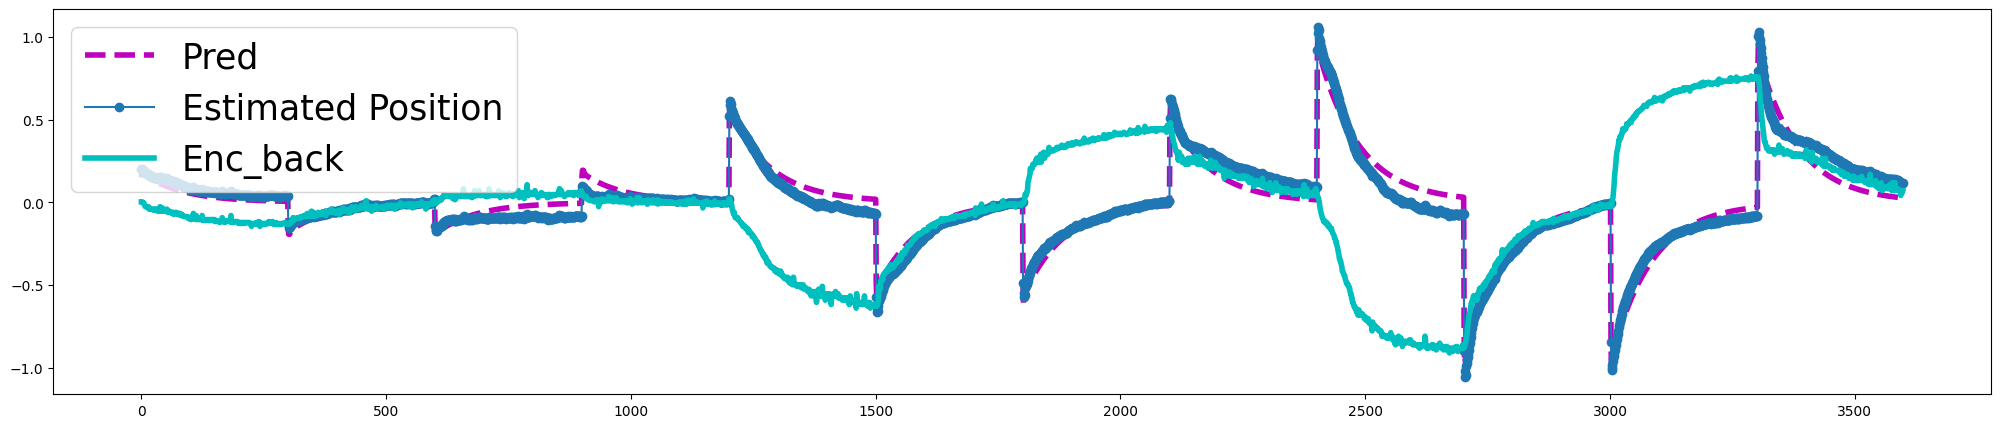

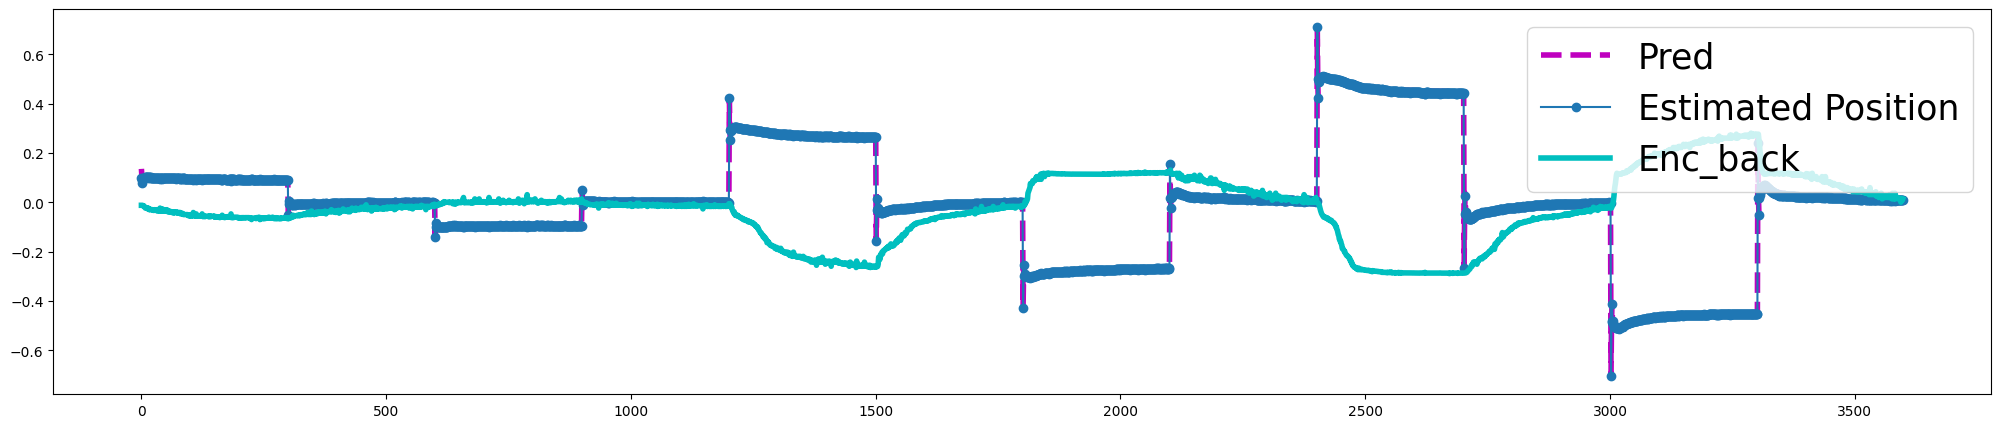

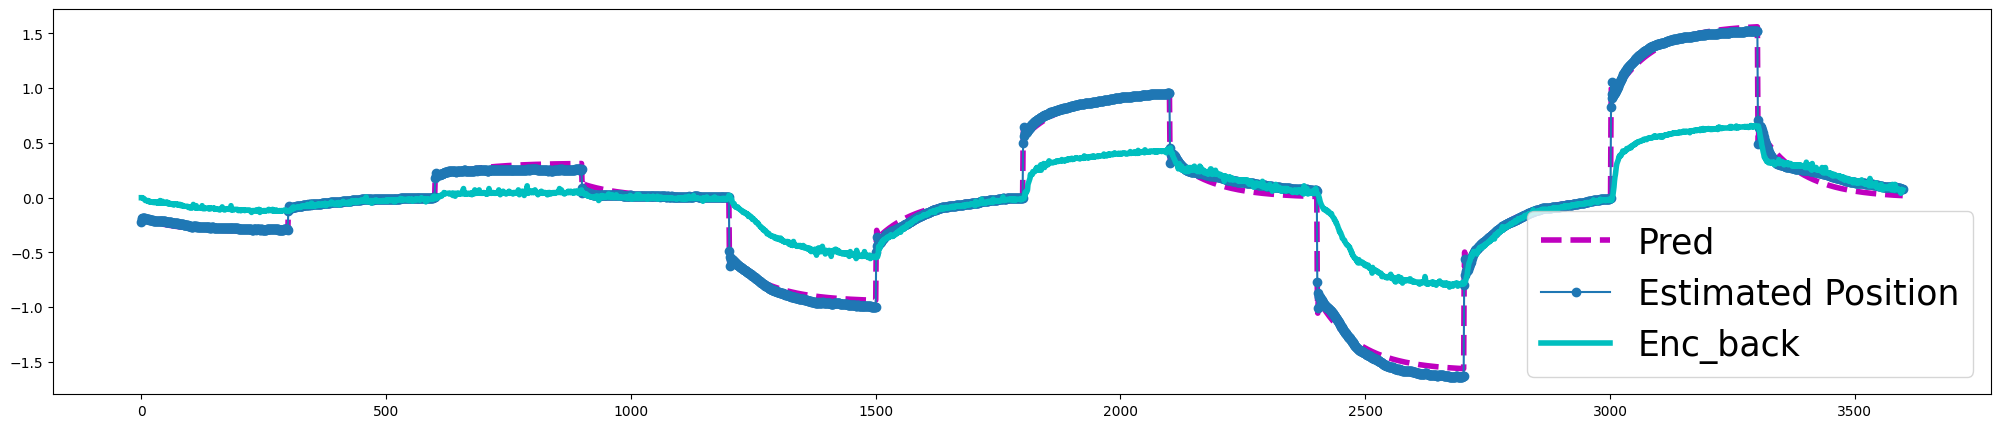

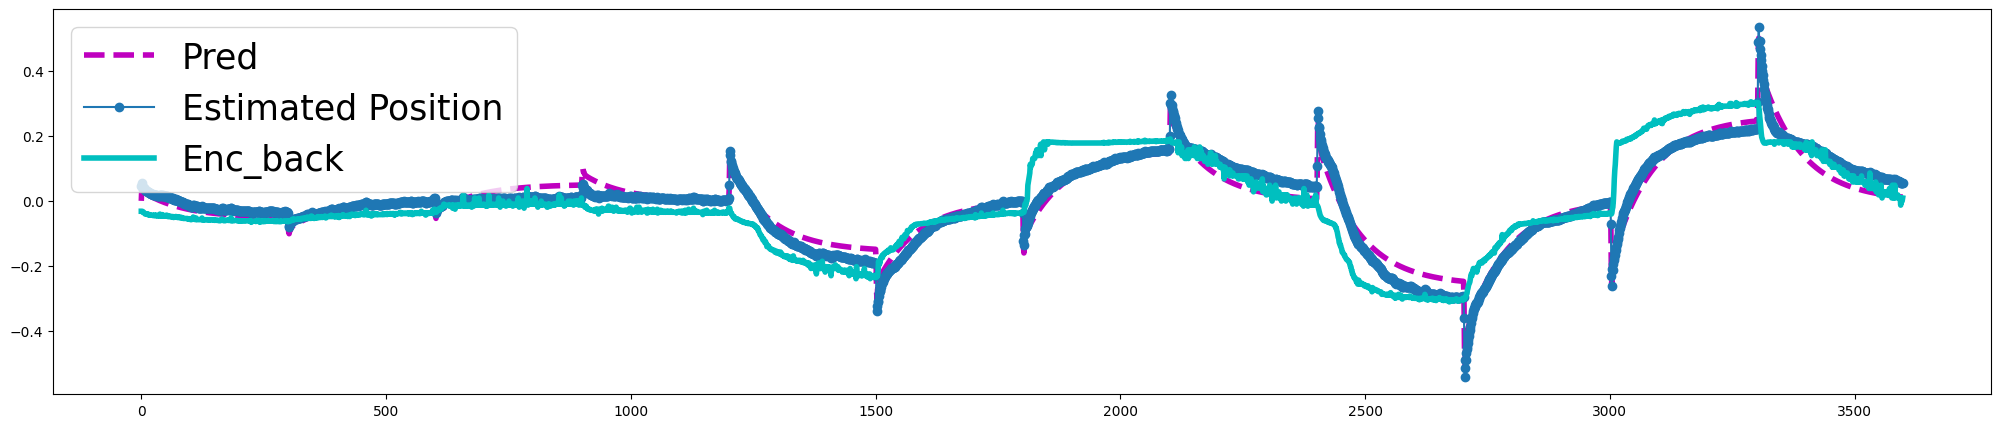

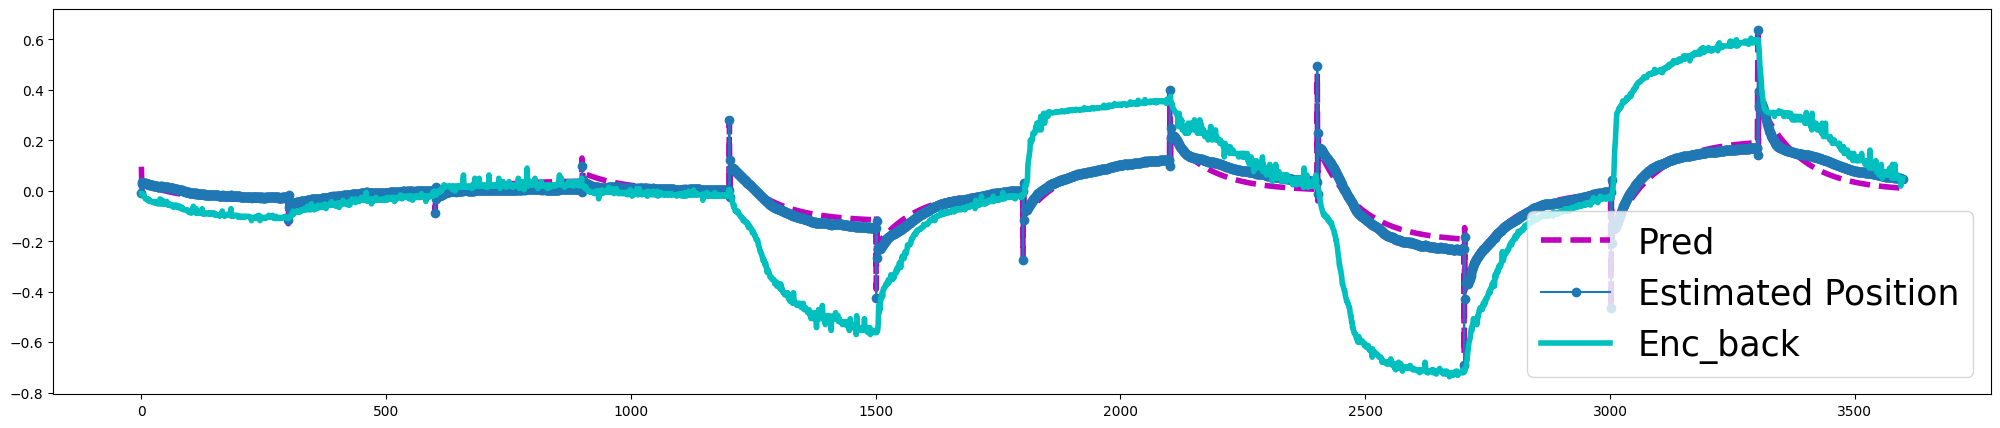

In [59]:
error = 0
error_ukf = 0
for i in range(nx_koopman):
    # plot lifted space traj, pred_x and x_enc for comparison
    plt.figure(figsize=(25, 5))
    plt.plot(pred_x[i, :part], 'm--', linewidth=4.0, label='Pred')
    plt.plot(estimated_states[:, i], label="Estimated Position", marker="o")
    plt.plot(x_enc['x'][0].detach().numpy()[:, i][:part], 'c', linewidth=4.0, label='Enc_back')
    plt.legend(fontsize=figsize)
    error = error + np.mean((pred_x[i, :part] - x_enc['x'][0].detach().numpy()[:, i][:part]) ** 2)
    error_ukf = error_ukf + np.mean((pred_x[i, :part-1] - estimated_states[:, i][:part-1]) ** 2)
# print total mse
print(error/nx_koopman)
print(error_ukf/nx_koopman)     
# mse = 0.1854 for latent 1, pred 80
# mse = 0.1633 for latent 10, pred 80
# mse = 0.1653 for latent 10, pred 200
print(x_enc['x'][0].detach().numpy()[:, :][0])
print(pred_x[:,0])


In [158]:
A = K.weight.detach().numpy()
B = f_u.weight.detach().numpy()

np.save('./data/A_noC.npy', A)
np.save('./data/B_noC.npy', B)
#np.save('./data/C_DeReK_False.npy', C)

In [159]:
def controllability_test(A, B):
    """
    Test the controllability of a system given state-space matrices A and B.

    Parameters:
    A (ndarray): State matrix of size (n, n)
    B (ndarray): Input matrix of size (n, m)

    Returns:
    bool: True if the system is controllable, False otherwise.
    """
    n = A.shape[0]  # Number of states
    controllability_matrix = B
    
    # Compute [B, AB, A^2B, ..., A^(n-1)B]
    for i in range(1, n):
        controllability_matrix = np.hstack((controllability_matrix, np.linalg.matrix_power(A, i) @ B))
    
    # Check rank of the controllability matrix
    rank = np.linalg.matrix_rank(controllability_matrix)
    return rank == n

is_controllable = controllability_test(A, B)
print(f"System is controllable: {is_controllable}")

def analyze_controllability(A, B):
    n = A.shape[0]
    controllability_matrix = B
    for i in range(1, n):
        controllability_matrix = np.hstack((controllability_matrix, np.linalg.matrix_power(A, i) @ B))
    
    rank = np.linalg.matrix_rank(controllability_matrix)
    return controllability_matrix, rank

C_matrix, rank = analyze_controllability(A, B)
print("Controllability Matrix:")
print(C_matrix)
print(f"Rank: {rank}/{A.shape[0]}")



System is controllable: True
Controllability Matrix:
[[ 6.13575101e-01  3.77773009e-02 -3.62808593e-02  7.01340195e-03
   8.24008603e-03  8.31269845e-03  5.77512477e-03  6.06937567e-03
   6.47356687e-03  5.99074783e-03]
 [ 7.47075558e-01 -1.70603603e-01  1.46133276e-02 -1.15443738e-02
  -6.23333873e-03  4.17012675e-03 -4.44374094e-03 -2.60880147e-03
  -2.33279844e-03 -2.49001943e-03]
 [-6.41452298e-02 -1.57106623e-01  5.78040108e-02  4.27268865e-03
   1.72333214e-02  1.28995897e-02  1.09935068e-02  1.08322045e-02
   8.40765145e-03  7.46307755e-03]
 [-2.74846286e-01  1.42967567e-01 -1.21139117e-01  2.55900878e-03
  -5.27230557e-03 -6.46111509e-03 -1.99318724e-03 -5.86537225e-03
  -5.73496195e-03 -6.01377431e-03]
 [ 1.42498299e-01 -2.26101056e-01  4.39025760e-02 -3.16857249e-02
  -1.97260529e-02 -5.59614692e-03 -4.14186437e-03  4.58754948e-04
   1.09545654e-03  1.96225964e-03]
 [ 5.08713424e-01  9.96980965e-02 -1.54241053e-02  1.32033965e-02
  -3.60643938e-02 -1.67869963e-02 -1.36934137e

In [160]:
# compute Koopman eigenvalues and eigenvectors
if stable:
    eig, eig_vec = torch.linalg.eig(K.effective_W())
else:
    eig, eig_vec = torch.linalg.eig(K.weight)
# Koopman eigenvalues real and imaginary parts
eReal = eig.real.detach().numpy()
eImag = eig.imag.detach().numpy()
# unit circle
t = np.linspace(0.0, 2 * np.pi, 1000)
x_circ = np.cos(t)
y_circ = np.sin(t)

In [161]:
eigenvalues, eigenvectors = np.linalg.eig(A)

# Find the index of the dominant eigenvalue (largest magnitude)
dominant_index = np.argmax(np.abs(eigenvalues))

# Extract the dominant eigenvalue and corresponding eigenvector
dominant_eigenvalue = eigenvalues[dominant_index]
dominant_eigenvector = eigenvectors[:, dominant_index]

print("dominant eigenvalue is at index", dominant_index)
print("\nDominant Eigenvalue:", dominant_eigenvalue)
print("Corresponding Dominant Eigenvector:")
print(dominant_eigenvector)

dominant eigenvalue is at index 0

Dominant Eigenvalue: (0.9881434+0j)
Corresponding Dominant Eigenvector:
[-0.37653646+0.j  0.19098489+0.j -0.44179937+0.j  0.4567585 +0.j
 -0.27070737+0.j  0.42577654+0.j  0.03167569+0.j  0.30233672+0.j
  0.20266105+0.j  0.17285709+0.j]


In [162]:
A[:,0]

array([ 0.03314717,  0.08355362,  0.12892571, -0.09859434,  0.14929453,
       -0.25404087, -0.32743657,  0.19363949, -0.21079482, -0.07278187],
      dtype=float32)

Text(0.5, 0.98, 'Koopman operator eigenvalues')

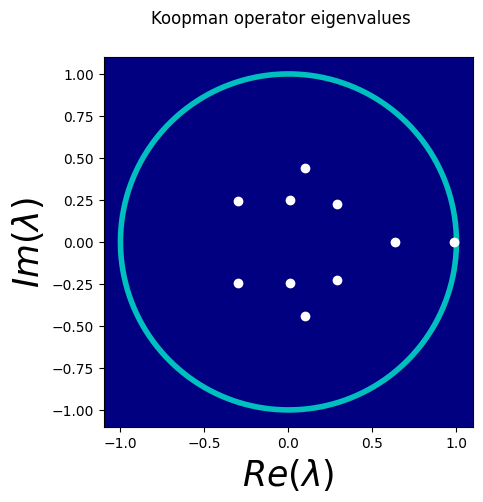

In [163]:
# plot Koopman eigenvalues
fig1, ax1 = plt.subplots()
ax1.plot(x_circ, y_circ, 'c', linewidth=4)
ax1.plot(eReal, eImag, 'wo')
ax1.set_aspect('equal', 'box')
ax1.set_facecolor("navy")
ax1.set_xlabel("$Re(\lambda)$", fontsize=figsize)
ax1.set_ylabel("$Im(\lambda)$", fontsize=figsize)
fig1.suptitle('Koopman operator eigenvalues')


In [164]:
# compute Koopman state eigenvectors
y_min = 1.1*test_data['Y'].min()
y_max = 1.1*test_data['Y'].max()
y1 = torch.linspace(y_min, y_max, 1000)
y2 = torch.linspace(y_min, y_max, 1000)
yy1, yy2 = torch.meshgrid(y1, y1)
plot_yy1 = yy1.detach().numpy()
plot_yy2 = yy2.detach().numpy()
# eigenvectors
features = torch.stack([yy1, yy2]).transpose(0, 2)
latent = f_y(features)
phi = torch.matmul(latent, abs(eig_vec))
# select first 6 eigenvectors
phi_1 = phi.detach().numpy()[:,:,0]
phi_2 = phi.detach().numpy()[:,:,1]
phi_3 = phi.detach().numpy()[:,:,2]
phi_4 = phi.detach().numpy()[:,:,3]
phi_5 = phi.detach().numpy()[:,:,4]
phi_6 = phi.detach().numpy()[:,:,6]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1000000x2 and 1x60)

In [1]:
# plot eigenvectors
fig2, axs = plt.subplots(2, 3)
im1 = axs[0,0].imshow(phi_1)
im2 = axs[0,1].imshow(phi_2)
im3 = axs[0,2].imshow(phi_3)
im4 = axs[1,0].imshow(phi_4)
im5 = axs[1,1].imshow(phi_5)
im6 = axs[1,2].imshow(phi_6)
fig2.colorbar(im1, ax=axs)
fig2.suptitle('first six eigenfunctions')

NameError: name 'plt' is not defined

# Optimal Control


In [2]:
import sys
sys.path.append('../functions')

import numpy as np
from scipy.linalg import expm
import dense
import cvxpy as cp
import matplotlib.pyplot as plt

In [3]:
def get_x(y):
    x = problem.nodes[0]({"Y0": torch.from_numpy(y).float()})
    return x["x"].detach().numpy().reshape(1,-1).T

def get_y(x):
    y = problem.nodes[4]({"x": torch.from_numpy(x.T).float()})
    return y["yhat"][0].detach().numpy().reshape(1,-1).T

def get_vector_y(x):
    y = problem.nodes[4]({"x": torch.from_numpy(x.T).float()})
    return y["yhat"].detach().numpy().reshape(1,-1).T

In [ ]:
x0 = get_x(np.array(([[1.0]])))
x_ = x0
for i in range(100):
    y = get_y(x_)
    x_ = get_x(y)

print(sum(x0-x_)**2)

# 1 --> 6.1389
# 10 --> 1.4665
# 100 ---> 0.00010013s

NameError: name 'problem' is not defined

In [5]:
Qx = np.zeros((nx_koopman,nx_koopman))
Qx[0,0] = 1
x_for = get_x(np.array([[0]]))
Qx = np.diag( 1/(x_for[:,0]**2) )
#Qx[1,1] = 1
Qx = np.eye(nx_koopman)
Qu = np.eye(nu)*0.000001

sim_len = 400
N = 40

umax = scalerU.transform(np.array([[100]]))
umin = scalerU.transform(np.array([[20]]))

x = np.zeros((nx_koopman, sim_len+1))
u = np.zeros((nu, sim_len+1))
y = np.zeros((ny, sim_len))
#x0 = get_x(np.array([[1]]))
x_in_0 = get_x(np.array([[0]]))
# x_ = x0
# for i in range(1000):
#     x_ = A@x_ + B@scalerU.transform(np.array([[50]]))
# x_in_0 = x_
# x_ = x0[:,0]
# print(sum(x_))
# for i in range(5000):
#     x_ = A@x_ + B@scalerU.transform(np.array([[50]]))[:,0]
# print(sum(x_))

# x0 = x_.reshape(-1,1)

x0 = get_x(np.array([[1.0]]))

x[:,0] = x0[:,0]
#x0 = x0 - x_in_0

NameError: name 'nx_koopman' is not defined

In [6]:
x0.shape

NameError: name 'x0' is not defined

In [ ]:
start = tim.time()
for i in range(sim_len):
    Q = dense.quad_form_sr(A, B, Qx, Qu, N)
    c = dense.lin_form_sr(A, B, Qx, N, x0)
    F = dense.constraint_matrix_sr_nox(N)
    g = dense.upper_bound_sr_nox(N,umax, umin)
    
    U = cp.Variable((N, nu))
    
    objective = cp.Minimize(cp.quad_form(U, Q) + c @ U)
    constraints = [F @ U <= g]
    
    problem_mpc = cp.Problem(objective, constraints)
    problem_mpc.solve()
    
    print(problem_mpc.objective.value)
    print(U.value)
    u[:, i] = U.value[0, :].reshape(-1, 1)
    
    # propagation in time
    x[:, i+1] = A @ x[:, i] + B @ u[:, i]
    y[:, i] = get_y(x[:, i+1])
    
        
    x0 = get_x(y[:,i])[:,0] #x[:, i+1] #- x_in_0[:,0] #get_x(y[:,i])[:,0]
    #print(sum(x0))
    print(i)
end = tim.time()
print(f"Elapsed time MPC: {end-start:.2f} sec")

NameError: name 'tim' is not defined

In [ ]:
u_desc = scalerU.inverse_transform(u.T)
plt.plot(u_desc)

NameError: name 'scalerU' is not defined

In [51]:
y = get_vector_y(x)


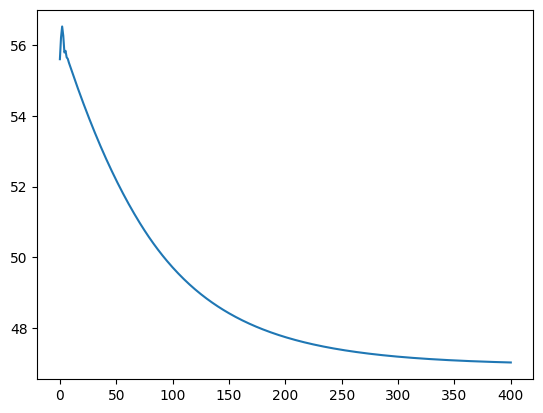

In [52]:
y_desc = scaler.inverse_transform(y)
plt.plot(y_desc)

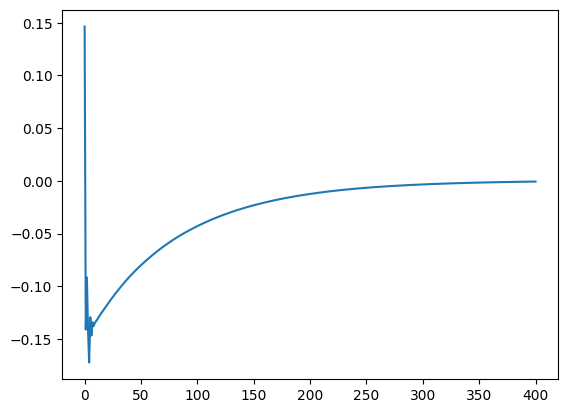

In [53]:
plt.plot(x[0,:])

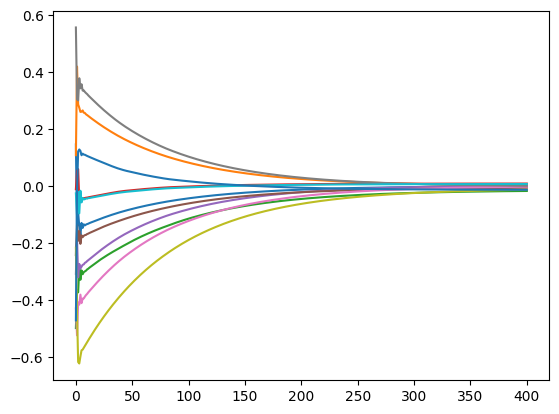

In [54]:
for i in range(nx_koopman):
    plt.plot(x[i,:])

In [55]:
x[0,0]-x_in_0[0]

array([0.14550793], dtype=float32)

# To reference

In [84]:
u = scalerU.transform(np.array([[30]]))[:,0]
x = get_x(scaler.transform(np.array([[36.56215]])))[:,0]
print(x)
for i in range(1000):
    x = A@x + B@u
print(x)
print(scaler.inverse_transform(get_y(x)))
print(get_x(get_y(x))[:,0])
x_store = x

[-0.16118781 -0.0840294   0.4370221  -0.22413442  0.3997547   0.36496225
  0.49624982 -0.64546484  0.11036161  0.12251185  0.56564724]
[-0.06932876 -0.06710585  1.90409051 -1.21752271 -0.49757508  0.57557333
 -0.1632056   0.24821646  1.03307008 -1.00964686  1.84887348]
[[35.14972]]
[-0.17990905 -0.10089081  0.48805577 -0.26355195  0.45397258  0.4146208
  0.56912816 -0.73439306  0.12955707  0.14614281  0.64357615]


In [85]:
# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(A)

# Find the indices of the dominant eigenvalues
dominant_indices = np.argsort(-np.abs(eigenvalues))  # Sort by absolute value in descending order
dominant_eigenvalues = eigenvalues[dominant_indices]

# Output results
print("Eigenvalues:", eigenvalues)
print("Dominant Eigenvalues:", dominant_eigenvalues)
print("Indices of Dominant Eigenvalues:", dominant_indices)


Eigenvalues: [ 0.9882058 +0.j         -0.4954663 +0.24588355j -0.4954663 -0.24588355j
  0.23539482+0.34724897j  0.23539482-0.34724897j  0.2938968 +0.10638515j
  0.2938968 -0.10638515j  0.0046915 +0.28640994j  0.0046915 -0.28640994j
 -0.33488926+0.j         -0.17142197+0.j        ]
Dominant Eigenvalues: [ 0.9882058 +0.j         -0.4954663 +0.24588355j -0.4954663 -0.24588355j
  0.23539482+0.34724897j  0.23539482-0.34724897j -0.33488926+0.j
  0.2938968 +0.10638515j  0.2938968 -0.10638515j  0.0046915 +0.28640994j
  0.0046915 -0.28640994j -0.17142197+0.j        ]
Indices of Dominant Eigenvalues: [ 0  1  2  3  4  9  5  6  7  8 10]


In [120]:
Qx = np.zeros((nx_koopman,nx_koopman))
for i in range(nx_koopman):
    if dominant_indices[i] <= 5:
        Qx[i,i] = 10
    else:
        Qx[i,i] = 1
x_for = get_x(np.array([[0]]))
#Qx = np.diag( 1/(x_for[:,0]**2) )
#Qx = np.eye(nx_koopman)
Qu = np.eye(nu)*0.1

sim_len = 400
N = 40

umax = scalerU.transform(np.array([[100]]))
umin = scalerU.transform(np.array([[20]]))

x = np.zeros((nx_koopman, sim_len+1))
u = np.zeros((nu, sim_len+1))
y = np.zeros((ny, sim_len))

x_in_0 = get_x(np.array([[0]]))


x0 = get_x(scaler.transform(np.array([[60]])))
x_ref = np.array([x_store]).T #get_x(scaler.transform(np.array([[30]])))
u_prev = scalerU.transform(np.array([[20]]))

x[:,0] = x0[:,0]

In [ ]:
start = tim.time()
for i in range(sim_len):
    Q = dense.quad_form_cr(A, B, Qx, Qu, N)
    c = dense.lin_form_cr(A, B, Qx, Qu, N, x0, x_ref, u_prev)
    F = dense.constraint_matrix_sr_nox(N)
    g = dense.upper_bound_sr_nox(N,umax, umin)
    
    U = cp.Variable((N, nu))
    
    objective = cp.Minimize(cp.quad_form(U, Q) + c @ U)
    constraints = [F @ U <= g]
    
    problem_mpc = cp.Problem(objective, constraints)
    problem_mpc.solve()
    
    print(problem_mpc.objective.value)
    #print(U.value)
    u[:, i] = U.value[0, :].reshape(-1, 1) #scalerU.transform(np.array([[75]]))#U.value[0, :].reshape(-1, 1)
    
    # propagation in time
    x[:, i+1] = A @ x[:, i] + B @ u[:, i]
    y[:, i] = get_y(x[:, i+1])
    
        
    x0 = get_x(y[:,i])[:,0] #x[:, i+1] #- x_in_0[:,0] #get_x(y[:,i])[:,0]
    u_prev = u[:,i]
    #print(sum(x0))
    print(i)
end = tim.time()
print(f"Elapsed time MPC: {end-start:.2f} sec")

-2061.220000570399
0
-2068.9066404897485
1
-2064.066337867492
2
-2065.689213171346
3
-2070.242823310708
4
-2072.654051229699
5
-2073.725197191481
6
-2075.1794494350042
7
-2076.4273725203234
8
-2077.8577071055443
9
-2079.226722510133
10
-2080.512631116947
11
-2081.798752834863
12
-2083.107107478137
13
-2084.348902762308
14
-2085.5550824929487
15
-2086.809734978313
16
-2088.053401372563
17
-2089.2935926755645
18
-2090.5287922098123
19
-2091.7950708641592
20
-2093.0732873548113
21
-2094.342751868471
22
-2095.609507213776
23
-2096.870424158513
24
-2098.1248497944575
25
-2099.335978678864
26
-2100.459212474325
27
-2101.577903964717
28
-2102.588415461354
29
-2103.5228265163023
30
-2104.527041814334
31
-2105.520731014199
32
-2106.5021741839328
33
-2107.4676242030055
34
-2108.4226844059754
35
-2109.367777091135
36
-2110.3090598662156
37
-2111.2422267050943
38
-2112.1505758359062
39
-2113.0689091615445
40
-2113.97673253676
41
-2114.8731414070553
42
-2115.7582546228814
43
-2116.632196474323
44
-

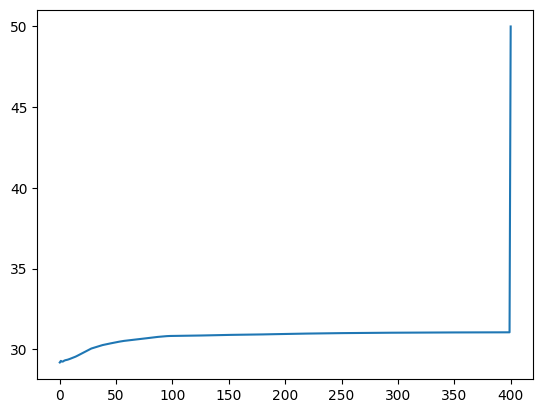

In [ ]:
plt.plot(scalerU.inverse_transform(u.T))

In [123]:
y = get_vector_y(x)


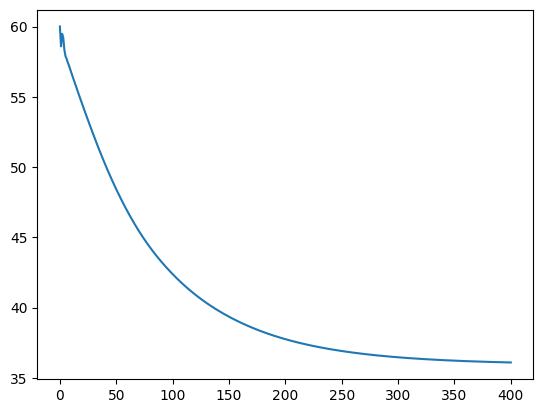

In [ ]:
y_desc = scaler.inverse_transform(y)
plt.plot(y_desc)

In [125]:
y_desc[-1]

array([36.100193], dtype=float32)

In [126]:
scaler.inverse_transform(get_y(x_ref))

array([[35.14972]], dtype=float32)

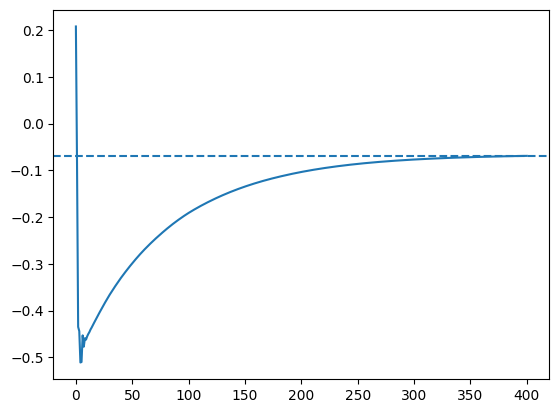

In [127]:
plt.plot(x[0,:])
plt.axhline(y = x_ref[0], linestyle = '--') 

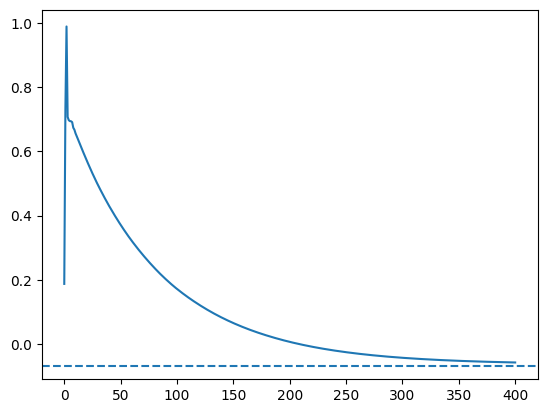

In [ ]:
plt.plot(x[1,:])
plt.axhline(y = x_ref[1], linestyle = '--') 

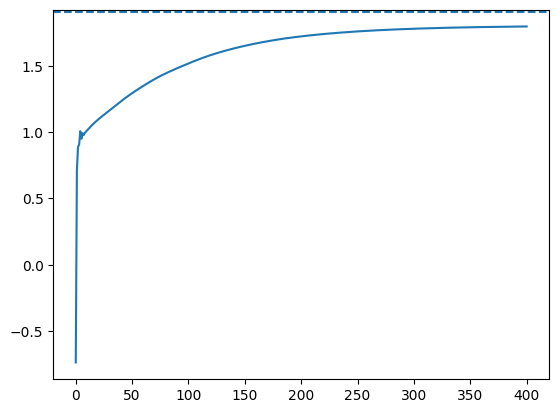

In [ ]:
plt.plot(x[2,:])
plt.axhline(y = x_ref[2], linestyle = '--') 

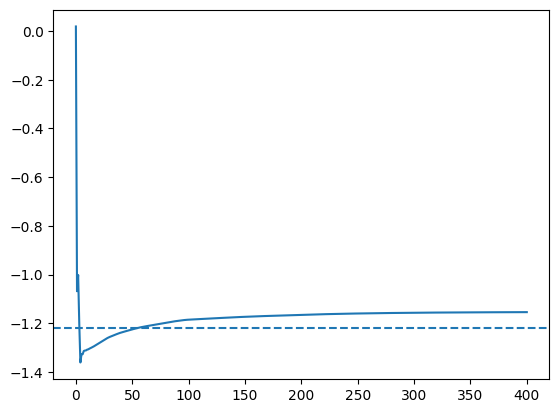

In [ ]:
plt.plot(x[3,:])
plt.axhline(y = x_ref[3], linestyle = '--') 

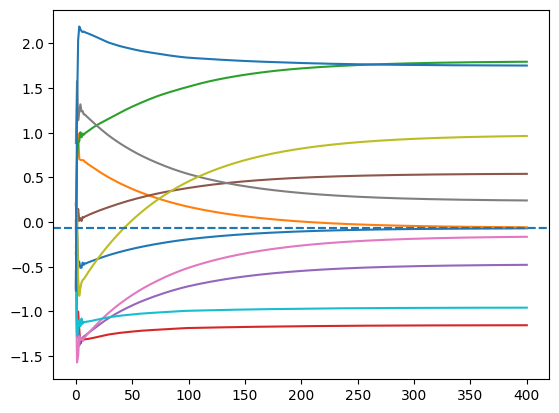

In [ ]:
for i in range(nx_koopman):
    plt.plot(x[i,:])
    
plt.axhline(y = x_ref[1], linestyle = '--') 
plt.axhline(y = x_ref[0], linestyle = '--') 
    